In [1]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
from gym.vector import SyncVectorEnv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import PIL
from PIL import Image
from IPython.core.display import clear_output

print(Image.__file__)

/home/lharms/.local/lib/python3.10/site-packages/PIL/Image.py


/tmp/ipykernel_30576/1252695180.py:15: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import clear_output


## Actor Critic

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, action_dim):
        super(ActorCritic, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.actor = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def extract_features(self, state):
        return self.cnn(state)

    def act(self, state):  # state: (B, C, H, W)
        with torch.no_grad():
            features = self.extract_features(state)              # (B, feature_dim)
            probs = self.actor(features)                         # (B, action_dim)
            dist = Categorical(probs)
            actions = dist.sample()                              # (B,)
            log_probs = dist.log_prob(actions)                   # (B,)
            entropy = dist.entropy()
            return actions, log_probs, entropy

    def evaluate(self, states, actions):
        features = self.extract_features(states)
        probs = self.actor(features)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        values = self.critic(features).squeeze(-1)
        return log_probs, entropy, values

#### A2C

In [3]:
class A2C:
    def __init__(self, action_dim, lr_actor, lr_critic, gamma):
        self.policy = ActorCritic(action_dim).to('cpu')
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma
        self.lam = 0.95 # für GAE

    def select_action(self, state):
        state_tensor = state.to("cpu") if isinstance(state, torch.Tensor) else torch.FloatTensor(state).to("cpu")
        return self.policy.act(state_tensor)

    def compute_gae(self, rewards, values, dones, next_value):
        T, N = rewards.size()  # (n_steps, num_envs)
        advantages = torch.zeros_like(rewards)
        gae = torch.zeros(N)

        for t in reversed(range(T)):
            mask = 1.0 - dones[t]
            delta = rewards[t] + self.gamma * next_value * mask - values[t]
            gae = delta + self.gamma * self.lam * mask * gae
            advantages[t] = gae
            next_value = values[t]

        returns = advantages + values
        return advantages, returns


    def update_parallel(self, states, actions, log_probs, rewards, dones, next_state_batch, entropies):
        # next_value: Critic-Wert des letzten Zustands (Bootstrap)
        with torch.no_grad():
            final_tensor = torch.FloatTensor(next_state_batch)
            next_value = self.policy.critic(self.policy.extract_features(final_tensor)).squeeze(-1)  # (num_envs,)

        # Sammle Werte (Critic) für alle vorherigen Zustände
        all_values = []
        for s in states:
            with torch.no_grad():
                v = self.policy.critic(self.policy.extract_features(s)).squeeze(-1)  # (num_envs,)
            all_values.append(v)

        # rewards, dones sind Listen aus (num_envs,) Tensoren
        values_tensor = torch.stack(all_values)  # (n_steps, num_envs)
        rewards_tensor = torch.stack(rewards_per_step)  # (n_steps, num_envs)
        dones_tensor = torch.stack(dones_per_step)  # (n_steps, num_envs)

        advantages, returns = self.compute_gae(
            rewards_tensor, values_tensor, dones_tensor, next_value
        )


        log_probs = torch.stack(log_probs)       # (n_steps, num_envs)
        actions = torch.stack(actions)           # (n_steps, num_envs)
        entropies = torch.stack(entropies)       # (n_steps, num_envs)

        states = torch.cat(states, dim=0)        # (n_steps * num_envs, ...)
        returns = returns.view(-1)               # (n_steps * num_envs,)
        actions = actions.view(-1)
        log_probs = log_probs.view(-1)
        entropy = entropies.view(-1)
        advantages = advantages.view(-1)

        # Vorteil normalisieren
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Aktueller Wert des Kritikers
        values = self.policy.critic(self.policy.extract_features(states)).squeeze(-1)

        actor_loss = - (log_probs * advantages).mean()
        critic_loss = torch.nn.functional.mse_loss(values, returns)
        loss = actor_loss + 0.5 * critic_loss - 0.1 * entropy.mean() # statt 0.03 #statt 0.01

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
        self.optimizer.step()

#### environment

In [4]:
def make_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v1')
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = SkipFrame(env, skip=frameskip)
        env = DeadlockEnv(env, threshold=(60 * 2) // frameskip)
        return env
    return _thunk

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=80):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3
        self.stage = 1
        self.world = 1
        self.last_coins = 0

        self.start_xpos = None

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        self.start_xpos = None
        self.lifes = 3
        self.stage = 1
        self.world = 1
        self.last_coins = 0

        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if self.start_xpos is None:
            self.start_xpos = x_pos

       # if x_pos > self.last_x_pos:
        #   reward += 2

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0

        if info['life'] != self.lifes or info["stage"] != self.stage or info["world"] != self.world:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']
            self.stage = info["stage"]
            self.world = info["world"]

        # ==== hier Veränderung ====
        coins_delta = info['coins'] - self.last_coins
        reward += min(coins_delta * 0.1, 2.0)  # statt coins_delta * 0.2
        self.last_coins = info['coins']

        if info.get("flag_get", False):
            reward += 20  # Bonus für Levelabschluss #statt 100
            done = True

        delta = x_pos - self.last_x_pos
        if delta > 0:
            reward += min(delta * 0.05, 2.0) # statt delta * 0.05 # statt 0.1
        else:
            reward -= 0.01 # stehenbleiben

        self.last_x_pos = x_pos
        # ===========================

        if self.count >= self.threshold:
            reward = -5 #statt 15
            done = True

        distance = x_pos - self.start_xpos
        info['distance'] = distance
        return state, reward, done, info


#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)


#### Training

In [5]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//4)

#plot for visualizing results
def plotRewardandTime(avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  x = np.arange(len(avg_norm_reward))

  fig, axs = plt.subplots(1, 2,figsize=(9,3))

  axs[0].plot(x, avg_norm_reward)
  axs[0].set_title("avg_norm_reward")

  axs[1].plot(x, avg_length)
  axs[1].set_title("avg_length")
  plt.show()

def get_base_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

def record(env, agent, max_steps=500):
    frames = []
    obs = env.reset()  # Altes Gym API, obs ist keine Tuple

    # Frame-Stack vorbereiten
    frame_buffer = deque(maxlen=frame_stack)

    # Erstes Bild preprocessen und Stack füllen
    img = GrayScale(Downsample(down_sample_rate, obs))
    img = cv2.resize(img, (84, 84)) / 255.0
    for _ in range(frame_stack):
        frame_buffer.append(img)

    done = False
    steps = 0

    while not done and steps < max_steps:
        # Frame fürs Video sammeln: Env liefert RGB Bild
        base_env = get_base_env(env)
        print(base_env)
        frame = base_env.render(mode="rgb_array")
        if frame is None:
            print("Frame is None!")
        elif frame.max() == 0:
            print("Frame ist komplett schwarz.")
        #else:
            #print(f"Frame OK: {frame.shape}, dtype={frame.dtype}")

        frames.append(frame)

        # Agent sieht den gepufferten Frame-Stack (4, 84, 84)
        state = np.stack(frame_buffer, axis=0)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # (1, 4, 84, 84)

        action, _, _ = agent.select_action(state_tensor)
        obs, reward, done, _ = env.step(action.item())

        # Neues Bild preprocessen und Stack aktualisieren
        img = GrayScale(Downsample(down_sample_rate, obs))
        img = cv2.resize(img, (84, 84)) / 255.0
        frame_buffer.append(img)

        #print(f"Step {steps}: action={action.item()}, reward={reward}, done={done}")
        steps += 1

    print(f"Gesammelte Frames: {len(frames)}")
    return frames


def save_video_cv2(frames, path, fps=15):
    if not frames:
        print("Keine Frames zum Speichern!")
        return

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(path, fourcc, fps, (width, height))

    for i, frame in enumerate(frames):
        bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(bgr)
        if (i + 1) % 100 == 0:
            print(f"{i+1}/{len(frames)} Frames geschrieben...")

    out.release()
    print(f"Video erfolgreich gespeichert: {path}")


/home/lharms/.local/lib/python3.10/site-packages/gym/envs/registration.py:564: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/lharms/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Env 4 done! Reward: 182.97333333333327, Length: 157, Distance: 236
[DEBUG] x_pos: 368 | coins: 0 | distance: 328
Env 1 done! Reward: 228.9700000000006, Length: 193, Distance: 553
[DEBUG] x_pos: 582 | coins: 0 | distance: 542
Env 6 done! Reward: 185.58000000000067, Length: 208, Distance: 667
[DEBUG] x_pos: 592 | coins: 0 | distance: 552

=== EPOCH 1 SUMMARY ===
avg_reward: [199.17444444444482]
avg_length: [186.0]
avg_distance: [236, 553, 667]
Epoch 1 | Avg Reward: 199.17 | Avg Length: 186.0
Env 0 done! Reward: 317.4800000000009, Length: 260, Distance: 662
[DEBUG] x_pos: 702 | coins: 0 | distance: 662
Env 1 done! Reward: 201.39666666666656, Length: 174, Distance: 243
[DEBUG] x_pos: 530 | coins: 0 | distance: 490
Env 7 done! Reward: 182.76000000000204, Length: 372, Distance: 682
[DEBUG] x_pos: 587 | coins: 0 | distance: 547
Env 5 done! Reward: 174.65000000000322, Length: 477, Distance: 674
[DEBUG] x_pos: 719 | coins: 0 | distance: 679
Env 0 done! Reward: 187.30000000000058, Length: 220, D

/home/lharms/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (500,) and (1880,)

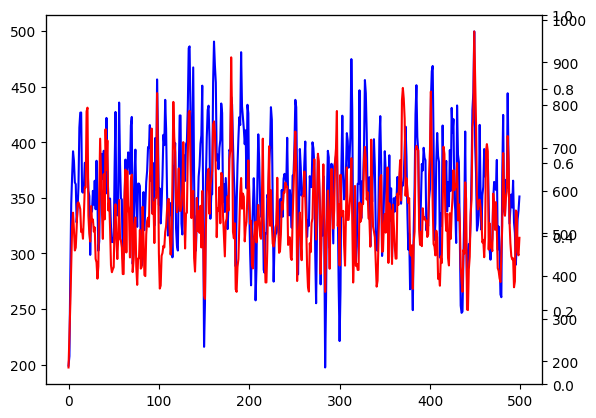

In [6]:
# ==== Hyperparameter ====
frameskip = 4
down_sample_rate = 4
lr_actor = 1e-4 # statt 0.0003
lr_critic = 5e-4 # statt 0.001
gamma = 0.995 # statt 0.99
frame_stack = 4
num_envs = 8
n_steps = 256 # statt 1000
max_epochs = 500
window_size = 10
video_env_id = 0

episode_rewards = [0.0 for _ in range(num_envs)]
episode_lengths = [0 for _ in range(num_envs)]

# Für Statistik
rewards_log = []
lengths_log = []
avg_reward = []
avg_length = []
avg_distance = []

# ==== Environment Setup ====
def make_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v1')
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = SkipFrame(env, skip=frameskip)
        env = DeadlockEnv(env, threshold=(60 * 2) // frameskip)
        return env
    return _thunk

envs = SyncVectorEnv([make_env() for _ in range(num_envs)])
render_env = make_env()()

action_dim = envs.single_action_space.n

# ==== Agent Setup ====
agent = A2C(action_dim=action_dim, lr_actor=lr_actor, lr_critic=lr_critic, gamma=gamma)

# ==== FrameStack Buffer pro Environment ====
frame_buffers = [deque(maxlen=frame_stack) for _ in range(num_envs)]
obs = envs.reset()

# Preprocessing initial state
def preprocess(obs):
    processed = []
    for i in range(num_envs):
        img = GrayScale(Downsample(down_sample_rate, obs[i]))
        img = cv2.resize(img, (84, 84)) / 255.0
        for _ in range(frame_stack):
            frame_buffers[i].append(img)
        processed.append(np.stack(frame_buffers[i], axis=0))
    return np.stack(processed)

state_batch = preprocess(obs)

# ==== Training Loop ====
for epoch in range(max_epochs):
    all_states, all_actions, all_log_probs = [], [], []
    rewards_per_step, dones_per_step, entropy_per_step = [], [], []
    frames = []
    highest_length, highest_reward, highest_distance = 0, 0, 0

    for _ in range(n_steps):
        state_tensor = torch.FloatTensor(state_batch)  # (num_envs, 4, 84, 84)
        actions, log_probs, entropies = agent.select_action(state_tensor)

        obs, rewards, dones, info = envs.step(actions.numpy())

        # Für Statistik
        for i in range(num_envs):
            episode_rewards[i] += rewards[i]
            episode_lengths[i] += 1

            if dones[i]:
                if episode_lengths[i] > highest_length:
                    highest_length = episode_lengths[i]
                elif episode_rewards[i] > highest_reward:
                    highest_reward = episode_rewards[i]
                print(f"Env {i} done! Reward: {episode_rewards[i]}, Length: {episode_lengths[i]}, Distance: {info['distance'][i]}")
                print(f"[DEBUG] x_pos: {info['x_pos'][0]} | coins: {info['coins'][0]} | distance: {info['distance'][0]}")
                rewards_log.append(episode_rewards[i])
                lengths_log.append(episode_lengths[i])
                episode_rewards[i] = 0.0
                episode_lengths[i] = 0
                if info['distance'][i] > highest_distance:
                    highest_distance = info['distance'][i]
                avg_distance.append(info['distance'][i])

        # nächster Zustand verarbeiten
        next_state_stack = []
        for i in range(num_envs):
            img = GrayScale(Downsample(down_sample_rate, obs[i]))
            img = cv2.resize(img, (84, 84)) / 255.0
            frame_buffers[i].append(img)
            stacked = np.stack(frame_buffers[i], axis=0)
            next_state_stack.append(stacked)
        state_batch = np.stack(next_state_stack)

        # Logging der Trainingsdaten
        all_states.append(state_tensor)
        all_actions.append(actions)
        all_log_probs.append(log_probs)
        rewards_per_step.append(torch.tensor(rewards, dtype=torch.float32))
        dones_per_step.append(torch.tensor(dones, dtype=torch.float32))
        entropy_per_step.append(entropies)


    # === Update ===
    agent.update_parallel(
        all_states, all_actions, all_log_probs,
        rewards_per_step, dones_per_step, state_batch,
        entropy_per_step
    )

    # === Statistik aktualisieren ===
    if len(rewards_log) >= window_size:
        # Gleitender Durchschnitt über letzte window_size Episoden
        avg_reward_epoch = np.mean(rewards_log[-window_size:])
        avg_length_epoch = np.mean(lengths_log[-window_size:])
    elif rewards_log:  # Falls weniger als window_size Episoden
        avg_reward_epoch = np.mean(rewards_log)
        avg_length_epoch = np.mean(lengths_log)
    else:
        # Fallback wenn noch keine Episoden beendet
        avg_reward_epoch = 0
        avg_length_epoch = 0

    avg_reward.append(avg_reward_epoch)
    avg_length.append(avg_length_epoch)

    print(f"\n=== EPOCH {epoch+1} SUMMARY ===")
    print("avg_reward:", avg_reward[-5:])
    print("avg_length:", avg_length[-5:])
    print("avg_distance:", avg_distance[-5:])
    print(f"Epoch {epoch+1} | Avg Reward: {avg_reward_epoch:.2f} | Avg Length: {avg_length_epoch:.1f}")

    if epoch % 50 == 0:
        torch.save(agent.policy.state_dict(), f"../../runs/A2C/03_testA2C/16_inc_entropy/a2c_epoch_{epoch}.pt")

        #frames = record(render_env, agent)
        #print(len(frames))
        #save_video_cv2(frames, f"../../runs/A2C/03_testA2C/10_reward_shaping_2/videos/mario_epoch{epoch}.mp4")


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

x = np.arange(len(avg_reward))
line1 = ax1.plot(x, avg_reward, 'b-', label='Avg Reward')
line2 = ax2.plot(x, avg_length, 'r-', label='Avg Length')
#line3 = ax3.plot(x, avg_distance, 'g-', label='Avg Distance')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Avg Reward', color='b')
ax2.set_ylabel('Avg Length', color='r')
#ax3.set_ylabel('Avg Distance', color='g')
plt.title("Training Progress")

fig.tight_layout()
fig.legend(loc="upper left")
plt.show()


print("===== Results =====")
print(f"Avg Reward: {np.mean(avg_reward):.2f} | Avg Length: {np.mean(avg_length):.2f} | Avg Distance: {np.mean(avg_distance):.2f}")
print(f"Highest Reward: {highest_reward} | Highest Length: {highest_length} | Highest Distance: {highest_distance}")